## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [13]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [14]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [15]:
import sqlite3

sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

#### Create Factorized 'category' column from 'Instruction_id' label column.

In [16]:
df_all['category'] = df_all['Instruction_id'].factorize()[0]

In [17]:
df_all.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [18]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [19]:
for i, row in df_all.iterrows():
    df_all.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

df_all = df_all.filter(['Instruction_id', 'category', 'selfdialog_norm'], axis=1)

df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table-2,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


In [20]:
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

#### Save New Cleaned File

In [21]:
df_all.to_csv('./data/dialog_norm.csv', index=False)
#df_all.to_sql('dialog_norm', con, if_exists='replace')

#### Get a Sample of records.

In [22]:
cat_id_df = df_all[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
cat_count = len(cat_id_df)
sample_size = 1000
sample_per_cat = sample_size//cat_count
print('sample_size: ', sample_size, 'sample_per_cat: ', sample_per_cat)

sample_size:  1000 sample_per_cat:  71


In [23]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group, k=sample_per_cat + 20):
    if len(group) < k:
        return group
    return group.sample(k, random_state=10)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to sample_size
corpus_df = corpus_df.sample(n=sample_size, random_state=3)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    74
coffee-ordering-1     79
coffee-ordering-2     71
movie-finder          41
movie-tickets-1       75
movie-tickets-2       72
movie-tickets-3       77
pizza-ordering-1      74
pizza-ordering-2      75
restaurant-table-1    71
restaurant-table-2    80
restaurant-table-3    63
uber-lyft-1           78
uber-lyft-2           70
dtype: int64


#### Generate Corpus List

In [24]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi starbucks coffee hi assist would like order iced black white mocha kind milk want whole milk want whipped cream whipped cream want whipped cream okanything specific nothing okyou pick order sec lincoln yosemite lone tree ok want make payment account starbucks okthen please provide account number details thanks come pick order come pick order min ok thanks anything else want thankshave good day good day',
 'hello want get uber would like go sumter mall city destination located sumter south carolina ok sumter mall located broad street sumter sc yes wish picked current location yes want use uber lift uber uber offer two options would like hear yes uber offers uberx current location uber xl would like repeat options would like first option first option uberx current location sumter mall broad street sumter south carolina would like order selection yes order created uber x ride current location sumter mall located broad street sumter sc cost correct say yes complete purchase yes order 

#### Build Vocabulary

In [25]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5994
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('time', 9), ('thank', 10)]


#### Build (context_words, target_word) pair generator

In [26]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [27]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hello', 'name', 'lewis', 'phone'] -> Target (Y): jerry
Context (X): ['name', 'jerry', 'phone', 'number'] -> Target (Y): lewis
Context (X): ['jerry', 'lewis', 'number', 'ask'] -> Target (Y): phone
Context (X): ['lewis', 'phone', 'ask', 'im'] -> Target (Y): number
Context (X): ['phone', 'number', 'im', 'famous'] -> Target (Y): ask
Context (X): ['number', 'ask', 'famous', 'one'] -> Target (Y): im
Context (X): ['ask', 'im', 'one', 'im'] -> Target (Y): famous
Context (X): ['im', 'famous', 'im', 'calling'] -> Target (Y): one
Context (X): ['famous', 'one', 'calling', 'reserve'] -> Target (Y): im
Context (X): ['one', 'im', 'reserve', 'table'] -> Target (Y): calling
Context (X): ['im', 'calling', 'table', 'next'] -> Target (Y): reserve


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [28]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 3, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 5, 5, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 3, 3, ..., 0, 0, 1]], dtype=int64)

In [31]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,want,pm,order,time,thank,please,tickets,one,need,...,mailbox,cracked,taillight,form,aviana,nevahstai,rear,whataboutburger,seater,uberxls,mexico,advised,fro,wirelessly,mchenry
0,0,1,3,10,0,5,2,2,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,2,0,0,5,0,4,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,5,5,1,0,6,2,0,3,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,2,1,1,0,2,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,12,0,0,2,1,0,3,0,1,5,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,1,9,0,2,5,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
996,0,2,2,3,0,1,4,3,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
997,0,1,1,0,4,0,1,1,0,2,1,1,4,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,1,1,0,4,1,2,0,1,0,0,1,4,0,0,...,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0


In [32]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5994)
(250, 5994)
(250,)


#### Define Model Builder Function

In [33]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [34]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [35]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [36]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7516356,0.7240000,0.7205469,0.7240000


In [37]:
from sklearn.metrics import confusion_matrix

rm_nb_bow.cm

array([[19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  8,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  7, 14,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 13,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3, 11,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  5,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 19,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  3],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10, 13]],
      dtype=int64)

In [38]:
from sklearn import metrics

print("Label" + rm_nb_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        19
 coffee-ordering-1       0.62      0.94      0.75        16
 coffee-ordering-2       0.88      0.47      0.61        15
      movie-finder       0.91      1.00      0.95        10
   movie-tickets-1       0.88      0.68      0.77        22
   movie-tickets-2       0.64      0.70      0.67        20
   movie-tickets-3       0.81      0.94      0.87        18
  pizza-ordering-1       0.59      0.76      0.67        17
  pizza-ordering-2       0.79      0.55      0.65        20
restaurant-table-1       0.50      0.57      0.53        14
restaurant-table-2       0.66      0.76      0.70        25
restaurant-table-3       0.90      0.53      0.67        17
       uber-lyft-1       0.79      0.52      0.63        21
       uber-lyft-2       0.57      0.81      0.67        16

          accuracy                           0.72       250
         macro avg       0.75    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

# def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
#     x_train_scaled, x_test_scaled = Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler)
#     X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, x_train_scaled, labels_train, x_test_scaled, labels_test)
#     rm_chi = Build_Model(model, X_train_chi, labels_train, X_test_chi, labels_test)
#     return rm_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [40]:
rows = []
scaler_min_max = MinMaxScaler()
for i in range(200, 5740, 100): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

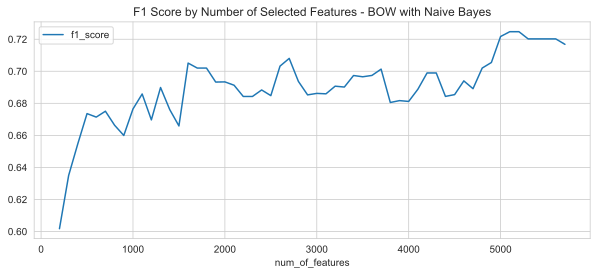

In [41]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [42]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

5150 5250 1


,num_of_features,f1_score,accuracy
50,5200,0.7247051,0.7280000
49,5100,0.7247051,0.7280000
48,5000,0.7217168,0.7240000
54,5600,0.7202214,0.7240000
53,5500,0.7202214,0.7240000


#### Get a more fine-grained look at the optimal number of features region

In [43]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

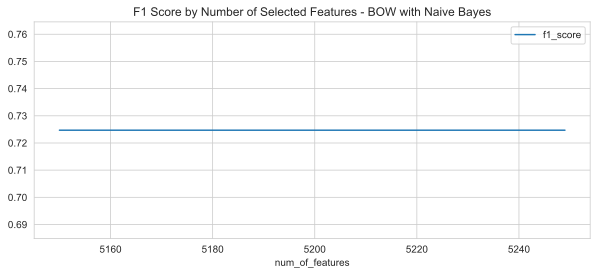

In [44]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [45]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

5150


,num_of_features,f1_score,accuracy
0,5150,0.7247051,0.7280000
63,5213,0.7247051,0.7280000
73,5223,0.7247051,0.7280000
72,5222,0.7247051,0.7280000
71,5221,0.7247051,0.7280000


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [46]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [47]:
print(rm_chi_opt_bow.cm)

[[19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  8  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  7 14  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4 17  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  9  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  3 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  4  3  0  0]
 [ 0  0  0  0  0  0  0  0  0  5 20  5  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 13]]


In [48]:
print("Label" + rm_chi_opt_bow.report)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        19
 coffee-ordering-1       0.62      0.94      0.75        16
 coffee-ordering-2       0.88      0.47      0.61        15
      movie-finder       1.00      1.00      1.00        10
   movie-tickets-1       0.88      0.68      0.77        22
   movie-tickets-2       0.64      0.70      0.67        20
   movie-tickets-3       0.81      0.94      0.87        18
  pizza-ordering-1       0.57      0.76      0.65        17
  pizza-ordering-2       0.79      0.55      0.65        20
restaurant-table-1       0.53      0.57      0.55        14
restaurant-table-2       0.67      0.80      0.73        25
restaurant-table-3       0.90      0.53      0.67        17
       uber-lyft-1       0.79      0.52      0.63        21
       uber-lyft-2       0.57      0.81      0.67        16

          accuracy                           0.73       250
         macro avg       0.76    

In [49]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.7516356,0.7240000,0.7205469,0.7240000
1,BOW Naive Bayes Optimal Features Selected: 5150,BOW,0.7565410,0.7280000,0.7247051,0.7280000


In [51]:
df_bow_train = pd.DataFrame(rm_chi_opt_bow.x_train_sel)
df_bow_train.to_csv('./data/bow_selected_train.csv', index=False)

df_bow_test = pd.DataFrame(rm_chi_opt_bow.x_ttest_sel)
df_bow_test.to_csv('./data/bow_selected_train.csv', index=False)

## Bag of N-Grams Feature Extraction

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

In [ ]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

In [ ]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
results_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [ ]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes baseline", "BONG", results_nb_bong, True, False)
df_benchmarks

In [ ]:
from sklearn.metrics import confusion_matrix

results_nb_bong.cm

In [ ]:
from sklearn import metrics

print(results_nb_bong.report)

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [ ]:
rows = []
for i in range(250, 5740, 50): # range(a, b, c) will count from a to b by intervals of c.
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

In [ ]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

#### Get a more fine-grained look at the optimal number of features region

In [ ]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
acc_df.sort_values(by='f1_score', ascending=False).head(5)

## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [ ]:
model_nb_bong_opt = MultinomialNB()
results_bong_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test, scaler_min_max)

In [ ]:
print(results_bong_opt.report)

In [ ]:
# Save benchmark output
Save_Benchmark("Bag of N-Gram Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BONG", results_bong_opt, False, False)
df_benchmarks

## TF-IDF Feature Extraction

In [ ]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

In [ ]:
vocab_tfidf = count_vect.get_feature_names()
pd.DataFrame(X_train_tfidf.toarray(), columns=vocab_tfidf)

## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [ ]:
clf = MultinomialNB()
results_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [ ]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [ ]:
from sklearn.metrics import confusion_matrix

results_nb_tfidf.cm

In [ ]:
from sklearn import metrics

print("Label" + results_nb_tfidf.report)

In [ ]:
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Baseline", "TF-IDF", results_nb_tfidf, True, False)
df_benchmarks

## Feature Selection - TF-IDF with Naive Bayes

In [ ]:
rows = []
scaler_max_abs = MaxAbsScaler()
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

#### Take closer look at region around optimal features

In [ ]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [ ]:
results_tf_nb_opt = SelectBestModelFeatures_Chi(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test, scaler_max_abs)
# Save benchmark output
Save_Benchmark("TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "TF-IDF", results_tf_nb_opt, False, False)
df_benchmarks

#### Metrics For Each Class

In [ ]:
from sklearn import metrics
print("Label" + results_tf_nb_opt.report)

## Word2Vec Feature Extraction

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

#### Visualizing word embeddings

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [ ]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [ ]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [ ]:
w2v_model.wv['jedi']

#### Build framework for getting document level embeddings

In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [ ]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

In [ ]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

scaler_min_max = MinMaxScaler()
#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Baseline", "Word2Vec", results_nb_w2v, True, False)
df_benchmarks

In [ ]:
results_nb_w2v.cm

In [ ]:
print("Label" + results_nb_w2v.report)

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [ ]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

In [ ]:
results_nb_w2v = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec", results_nb_w2v, False, False)
df_benchmarks

## Word2vec features Extraction with Fastext Model

In [ ]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [ ]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

#### PCA on Fasttext Model

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [ ]:
print(P.shape)

In [ ]:
ft_model.wv['rental']

In [ ]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

In [ ]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

## Word2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [ ]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

In [ ]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [ ]:
model_ft_nb = GaussianNB()
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec Fastext Naive Bayes Baseline", "Word2Vec_FT", results_nb_ft, True, False)
df_benchmarks

## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [ ]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [ ]:
results_nb_ft = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test, scaler_min_max)
# Save benchmark output
Save_Benchmark("Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "Word2Vec_FT", results_nb_ft, False, False)
df_benchmarks

## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [ ]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

#### Visualize GloVe word embeddings

In [ ]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

In [ ]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words_test])
print(word_glove_vectors_test.shape)

#### GloVe Embeddings with Flair

In [ ]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [ ]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

In [ ]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size):
        text = corpus[iter]
        if (text == ""):
            text = "blank"
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [ ]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

In [ ]:
pd.DataFrame(x_test_glove)

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_glove_nb = GaussianNB()
results_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [ ]:
print(results_nb_glove.report)

## Feature Selection on Glove Features with Naive Bayes Model

In [ ]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

In [ ]:
results_nb_glove = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test, scaler_min_max)

# Save benchmark output
# Save_Benchmark("Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "GloVe", results_nb_glove, False, False)
# df_benchmarks

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [ ]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size_total = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size_total))
    
    for i in range(0, row_size):
        for j in range(0, col_size_1):
            X[i, j] = feat_1[i, j]

        for k in range(col_size_1, col_size_total):
            X[i, k] = feat_2[i, k - col_size_1]
    return X

#### Combine Features Arrays together

In [ ]:
# Get Scaled BOW Features
x_bow_train_norm, x_bow_test_norn = Get_Scaled_Features(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, scaler_max_abs)

# Add Bag of nGrams
x_bong_train_norm, x_bong_test_norn = Get_Scaled_Features(results_bong_opt.x_train_sel, y_train, results_bong_opt.x_test_sel, y_test, scaler_max_abs)
x_train_bow_bong = Get_Combined_Features(x_bow_train_norm, x_bong_train_norm)
x_test_bow_bong = Get_Combined_Features(x_bow_test_norn, x_bong_test_norn)

# Add TF-IDF
# x_tfidf_train_norm, x_tfidf_test_norn = Get_Scaled_Features(results_tf_nb_opt.x_train_sel, y_train, results_tf_nb_opt.x_test_sel, y_test, scaler_max_abs)
# x_train_bow_bong = Get_Combined_Features(x_train_bow_bong, x_tfidf_train_norm)
# x_test_bow_bong = Get_Combined_Features(x_test_bow_bong, x_tfidf_test_norn)

# Add Word2Vec
# x_w2v_train_norm, x_w2v_test_norn = Get_Scaled_Features(results_nb_w2v.x_train_sel, y_train, results_nb_w2v.x_test_sel, y_test, scaler_max_abs)
# x_train_bow_bong = Get_Combined_Features(x_train_bow_bong, x_w2v_train_norm)
# x_test_bow_bong = Get_Combined_Features(x_test_bow_bong, x_w2v_test_norn)

In [ ]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

In [ ]:
pd.DataFrame(x_test_bow_bong)

In [ ]:
# model_bow_bong = GaussianNB() 
model_bow_bong = MultinomialNB()
results_nb_bow_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [ ]:
Save_Benchmark("BOW and Bag of N-Grams Combined Baseline", "BOW_BONG", results_nb_bow_bong, True, False)
df_benchmarks

In [ ]:
print("Label" + results_nb_bow_bong.report)

In [ ]:
rows = []
for i in range(100, 14600, 100): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

In [ ]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    results_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
    rows.append([i, results_i.f1_score, results_i.accuracy])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

In [ ]:
#model_bow_bong = GaussianNB() # = MultinomialNB()
results_nb_bow_bong = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test, scaler_min_max)
Save_Benchmark("BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", "BOW_BONG", results_nb_bow_bong, False, False)
df_benchmarks

## Try PCA Feature Extraction on the BOW Model 

In [ ]:
from sklearn.decomposition import PCA

# Define PCA Selection Function
def Get_PCA_Features(i,  X_train_pca, y_train_pca, X_test_pca, y_test_pca):
    pca = PCA(n_components=i)
    fit = pca.fit(X_train_pca, y_train_pca)
    pca_train = fit.transform(X_train_pca)
    pca_test = fit.transform(X_test_pca)
    return pca_train, pca_test

In [ ]:
# Loop through different no. of component values
model_nb_bow = GaussianNB()
rows = []
for i in range(5, 100, 1): # range(a, b, c) will count from a to b by intervals of c.
    x_train_pca_i, x_test_pca_i = Get_PCA_Features(i,  X_train_bow, y_train, X_test_bow, y_test)
    results_i = Build_Model(model_nb_bow, x_train_pca_i, y_train, x_test_pca_i, y_test)
    rows.append([i, results_i.f1_score, results_i.accuracy])
acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

In [ ]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with PCA", figsize=(10, 4))

In [ ]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

In [ ]:
x_train_pca, x_test_pca = Get_PCA_Features(Opt_no_of_feat,  X_train_bow, y_train, X_test_bow, y_test)
results_bow_pca = Build_Model(model_nb_bow, x_train_pca, y_train, x_test_pca, y_test)
Save_Benchmark("BOW With Top: " + str(Opt_no_of_feat) + "  PCA Components Seleted", "BOW_PCA", results_bow_pca, True, False)
df_benchmarks

In [ ]:
pd.DataFrame(x_train_pca)

## Feature Engineering, Extraction and Selection Final Results

In [ ]:
# Show All benchmarks
df_benchmarks_all

#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

In [ ]:
df_benchmarks_all.sort_values(by='f1_score', ascending=False).plot(x="Features_Benchedmarked", y="f1_score", kind='bar', title="Feature Benchmarking Results with F1 Score", figsize=(10, 4))

In [ ]:
df_benchmarks_all.boxplot(column=['f1_score'], by='Feat_Type', figsize=(10, 4))

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features
#### This gives us a visual on where the model is failing

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(rm_chi_opt_bow.cm, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
scaler_ma = MaxAbsScaler()
x_bow_train_norm, x_bow_test_norn = SelectAndScaleFeatures_0_1(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, scaler_ma)
x_bong_train_norm, x_bong_test_norn = SelectAndScaleFeatures_0_1(results_bong_opt.x_train_sel, y_train, results_bong_opt.x_test_sel, y_test, scaler_ma)
x_tfidf_train_norm, x_tfidf_test_norn = SelectAndScaleFeatures_0_1(results_tf_nb_opt.x_train_sel, y_train, results_tf_nb_opt.x_test_sel, y_test, scaler_ma)
x_w2v_train_norm, x_w2v_test_norn = SelectAndScaleFeatures_0_1(results_nb_w2v.x_train_sel, y_train, results_nb_w2v.x_test_sel, y_test, scaler_ma)

In [ ]:
df_x_opt = pd.DataFrame(x_w2v_train_norm)
# results_nb_ft.x_test_sel, results_nb_glove.x_test_sel)
df_x_opt

## Additional Research

### Custom Trained RNN Classifier Model using FLAIR with GloVe Embeddings

In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
#from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.data_fetcher import NLPTaskDataFetcher, NLPTask

corpus_df.columns

In [ ]:
# Uncomment this section to re-write data files
# c_df = corpus_df.filter(['selfdialog_norm','Instruction_id'], axis=1)
# c_df.columns = ['text', 'label_instruction_id']

# train, dev, test = np.split(c_df.sample(frac=1), [int(.6*len(c_df)), int(.8*len(c_df))])
# train.to_csv(r'.\flairdata\train.txt')
# dev.to_csv(r'.\flairdata\dev.txt')
# test.to_csv(r'.\flairdata\test.txt')

In [ ]:
# this is the folder in which train, test and dev files reside
data_folder = './flairdata'

# column format indicating which columns hold the text and label(s)
column_name_map = {1: "text", 2: "label_instruction_id"}

# load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter=',', 
)

In [ ]:
# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove'),

                   # comment in flair embeddings for state-of-the-art results
                   # FlairEmbeddings('news-forward'),
                   # FlairEmbeddings('news-backward'),
                   ]

In [ ]:
print(corpus)

In [ ]:
# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings: DocumentRNNEmbeddings = DocumentRNNEmbeddings(word_embeddings,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )

In [ ]:
# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/ag_news',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=6)

In [ ]:
from flair.embeddings import Sentence

# create example sentence
sentence = Sentence('France is the current world cup winner.')

# predict class and print
classifier.predict(sentence)

print(sentence.labels)